In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.formula.api import ols
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# load data
df_raw = pd.read_csv("./data/yield_csif_2017.csv", low_memory=False).iloc[:, 1:].dropna(subset=["yield"])
df_raw = df_raw[~df_raw["yield"].isin([np.inf, -np.inf])]

# fx to remove outliers by state
def remove_outliers(df):
    df = df.copy()
    grouped = df.groupby(["NAME_1", "cropname"])
    
    def filter_group(group):
        Q1 = group["yield"].quantile(0.25)
        Q3 = group["yield"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return group[(group["yield"] >= lower_bound) & (group["yield"] <= upper_bound)]
    
    return grouped.apply(filter_group).reset_index(drop=True)

df_clean = remove_outliers(df_raw)
df_clean = df_clean[(df_clean["yield"] != 0) & (~df_clean["cropname"].isin(["Potatoes", "Pulses nes", "Sweet potato", "Seed cotton"]))]

# aggregate data
forplot = df_clean.groupby(["year", "cropname", "NAME_1"])["yield"].mean().reset_index()
forplot2 = df_clean.groupby(["year", "cropname"])["yield"].mean().reset_index()

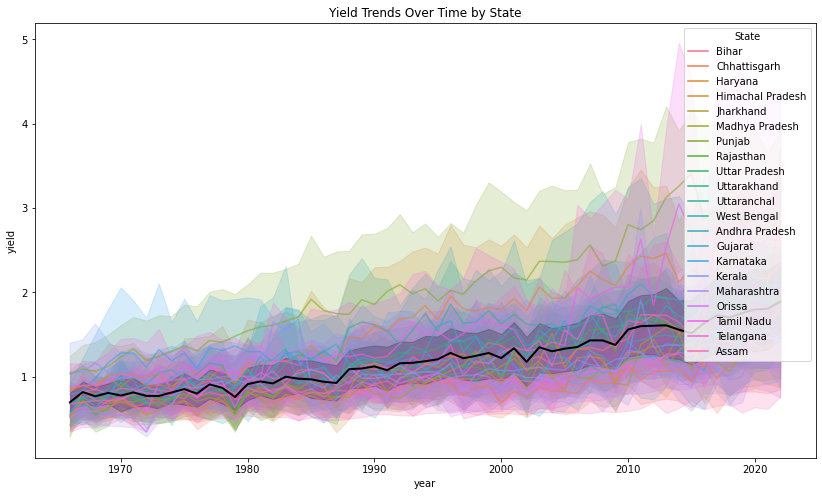

In [3]:
# plot yield trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=forplot, x="year", y="yield", hue="NAME_1", alpha=0.6)
sns.lineplot(data=forplot2, x="year", y="yield", color='black', linewidth=2)
plt.title("Yield Trends Over Time by State")
plt.legend(title="State", loc='upper right')
plt.show()

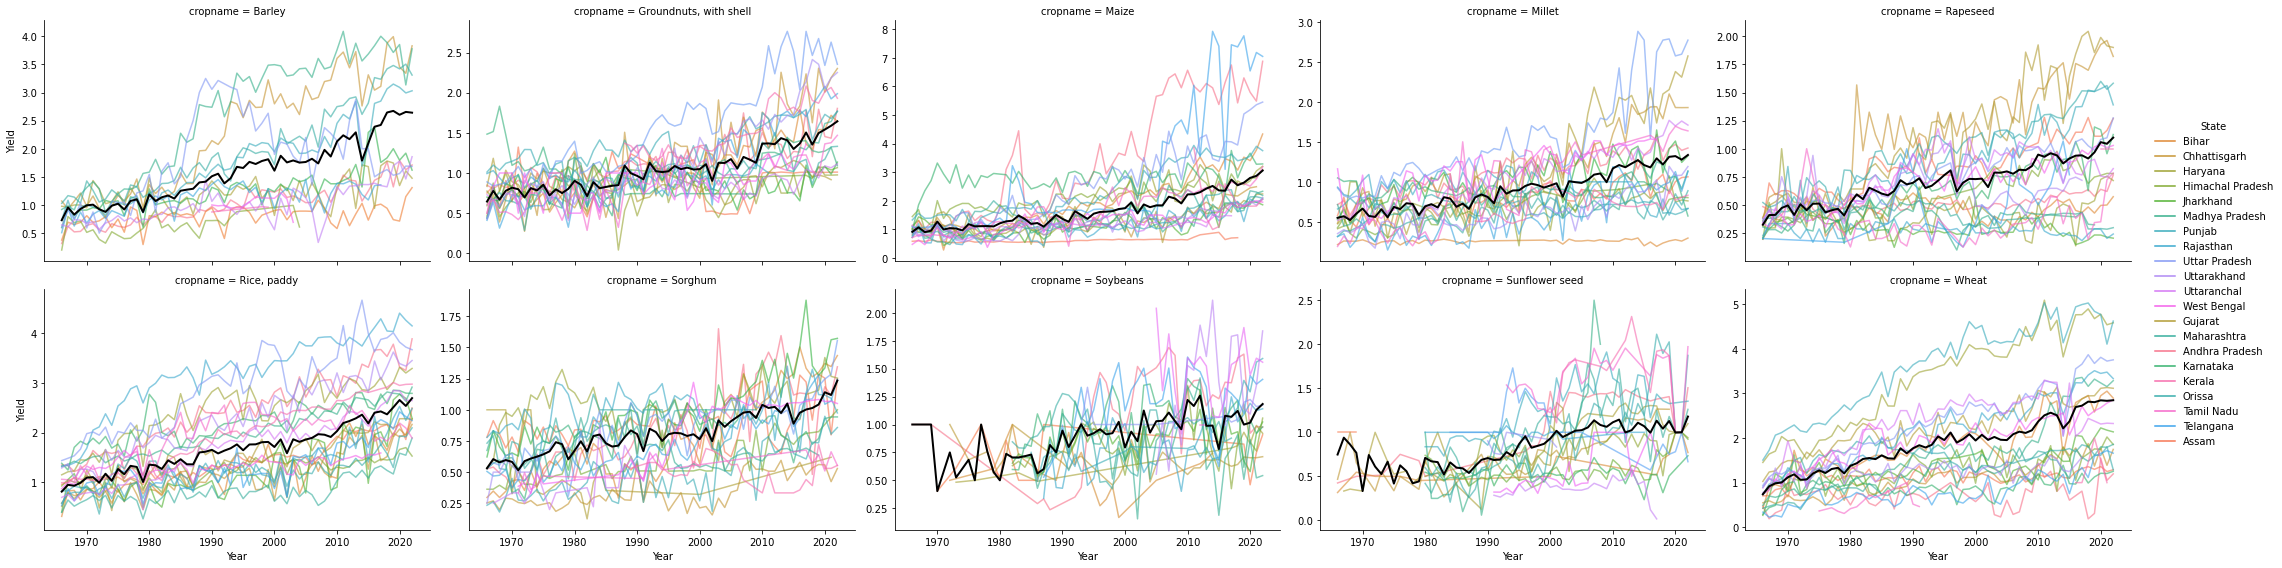

In [4]:
# same plot but faceted 

g = sns.FacetGrid(forplot, col="cropname", col_wrap=5, sharey=False, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x="year", y="yield", hue="NAME_1", alpha=0.6)

# Overlay the overall trend (forplot2) in black
for ax, crop in zip(g.axes.flatten(), forplot2["cropname"].unique()):
    subset = forplot2[forplot2["cropname"] == crop]
    sns.lineplot(data=subset, x="year", y="yield", color='black', linewidth=2, ax=ax, legend=False)

g.set_axis_labels("Year", "Yield")
g.add_legend(title="State")

plt.show()


In [5]:
# detrending and standardized anomalies

df_clean_dt = df_raw[~df_raw["cropname"].isin(["Potatoes", "Pulses nes", "Sweet potato", "Seed cotton"])].copy()

def detrend(df):
    df = df.copy()
    df = df.rename(columns={"yield": "yield_value"})  # Rename yield to avoid conflicts

    def fit_trend(group):
        if len(group) > 1:  # Ensure enough data to fit a model
            model = ols("yield_value ~ year", data=group).fit()
            group = group.copy()  # Ensure modifications don't cause indexing issues
            group["trend"] = model.predict(group["year"])
        else:
            group["trend"] = np.nan  # Assign NaN if not enough data
        return group

    df = df.groupby(["Name_12", "cropname"], group_keys=False).apply(fit_trend)  # Avoid hierarchical index issues
    df["yield_dt"] = df["yield_value"] - df["trend"]
    
    return df.rename(columns={"yield_value": "yield"}).reset_index(drop=True)  # Reset index properly

df_clean_dt = detrend(df_clean_dt)

In [6]:
def compute_anomalies(df):
    df = df.copy()
    grouped = df.groupby(["Name_12", "cropname"],group_keys=False)
    
    def normalize(group):
        mean_yield = group["yield_dt"].mean()
        sd_yield = group["yield_dt"].std()
        group["standardized_anomaly"] = (group["yield_dt"] - mean_yield) / sd_yield
        return group
    
    df = grouped.apply(normalize).reset_index(drop=True)
    return df

df_clean_anom = compute_anomalies(df_clean_dt)
forplot_anom = df_clean_anom.groupby(["NAME_1", "cropname", "year"], group_keys=False)["standardized_anomaly"].mean().reset_index()
forplot_anom2 = df_clean_anom.groupby(["year", "cropname"], group_keys=False)["standardized_anomaly"].mean().reset_index()

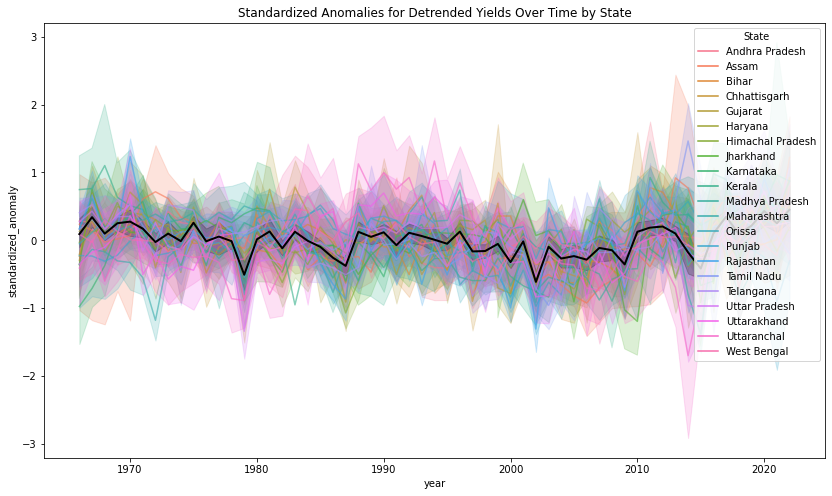

In [7]:
# Plot standardized anomalies
plt.figure(figsize=(14, 8))
sns.lineplot(data=forplot_anom, x="year", y="standardized_anomaly", hue="NAME_1", alpha=0.6)
sns.lineplot(data=forplot_anom2, x="year", y="standardized_anomaly", color='black', linewidth=2)
plt.title("Standardized Anomalies for Detrended Yields Over Time by State")
plt.legend(title="State", loc='upper right')
plt.show()

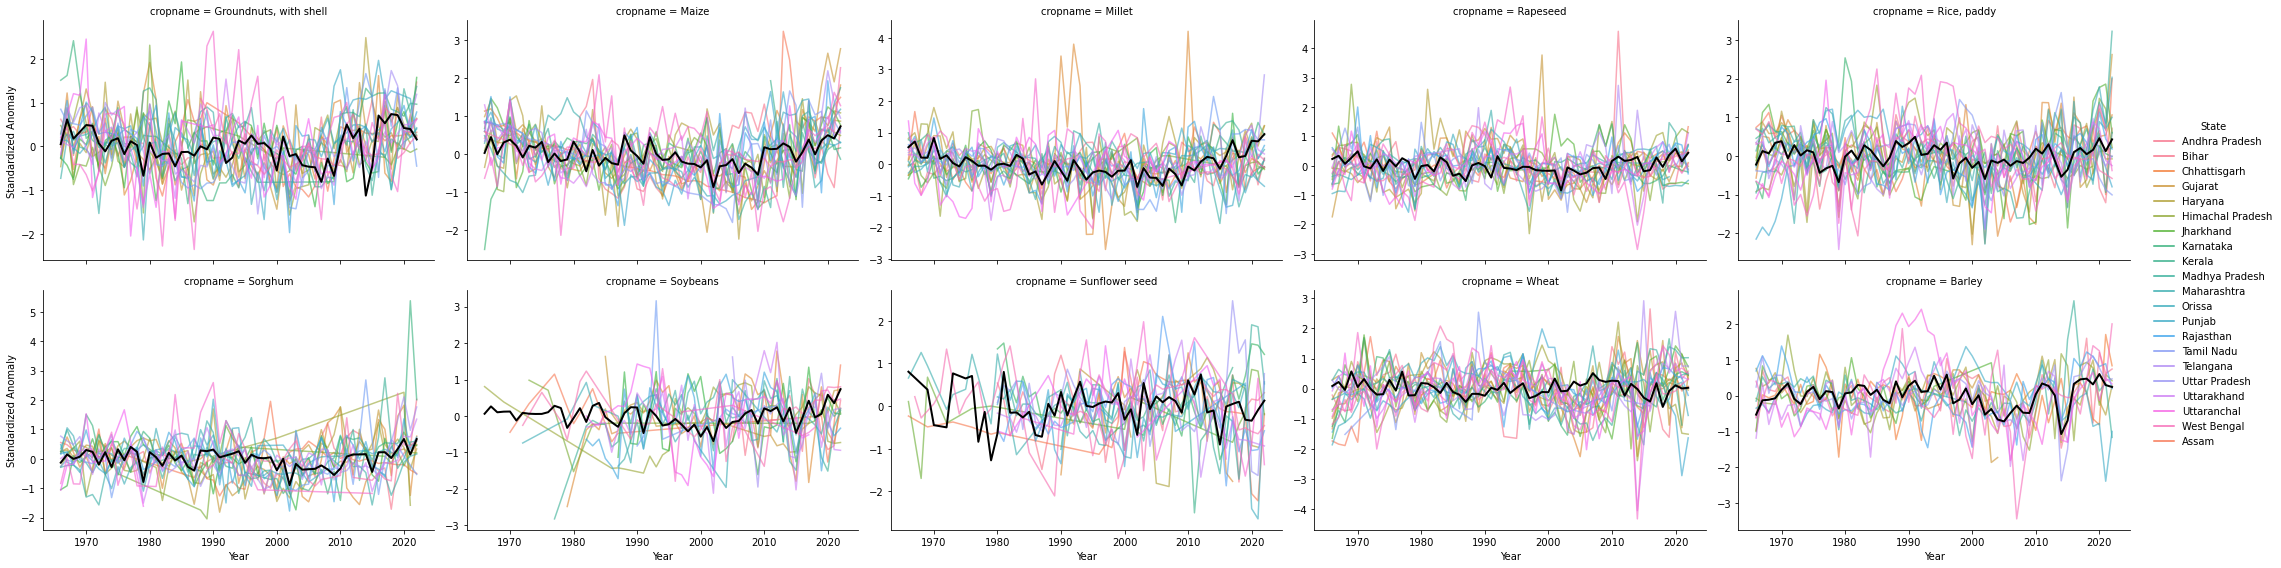

In [8]:
g = sns.FacetGrid(forplot_anom, col="cropname", col_wrap=5, sharey=False, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x="year", y="standardized_anomaly", hue="NAME_1", alpha=0.6)

# Overlay the overall trend (forplot2) in black for each crop
for ax, crop in zip(g.axes.flatten(), forplot2["cropname"].unique()):
    subset = forplot_anom2[forplot_anom2["cropname"] == crop]
    sns.lineplot(data=subset, x="year", y="standardized_anomaly", color='black', linewidth=2, ax=ax, legend=False)

g.set_axis_labels("Year", "Standardized Anomaly")
g.add_legend(title="State")

plt.show()


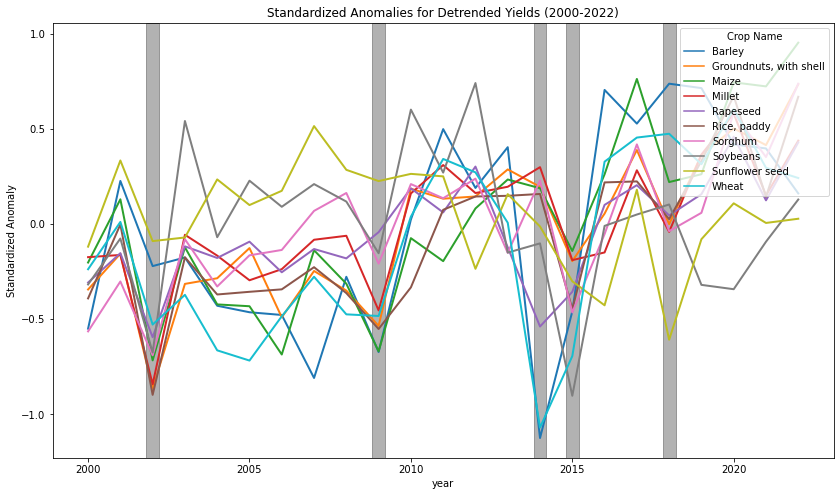

In [9]:
# Filter for 2000-2022
forplot_anom00 = df_clean_anom[df_clean_anom["year"].between(2000, 2022)].groupby(["NAME_1", "cropname", "year"])["standardized_anomaly"].mean().reset_index()
forplot_anom002 = df_clean_anom[df_clean_anom["year"].between(2000, 2022)].groupby(["year", "cropname"])["standardized_anomaly"].mean().reset_index()

# Plot anomalies with key years highlighted
plt.figure(figsize=(14, 8))
sns.lineplot(data=forplot_anom002, x="year", y="standardized_anomaly", hue="cropname", linewidth=2)
for year in [2002, 2009, 2014, 2015, 2018]:
    plt.axvspan(year-0.2, year+0.2, color='black', alpha=0.3)
plt.title("Standardized Anomalies for Detrended Yields (2000-2022)")
plt.ylabel("Standardized Anomaly")
plt.legend(title="Crop Name", loc='upper right')
plt.show()
